In [1]:
from mnist import MNIST 
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [2]:
labels = mndata.train_labels

cluster_size = 10
train_inputs_idx = []
for idx in range(10):
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

100

# TODO: Winner's stats synapse.
# TODO: Bio_hebbian stats synapse.
# TODO: Stats synapse for each rez.synapse, not only for winners.
# TODO: Stats synapse for winners and second after winner.
# TODO: Push stats synapses.
# TODO: Rezonanse synapse via avg(or meadian) input. AVG input as dW!

In [97]:
layer_size = 10*4

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
W = np.random.rand(O.size, I.size) * 0.001
print('W', W.shape, W.max(), W.min(), np.median(W))

WinC = np.ones(O.shape)[np.newaxis].T
S = np.ones(W.shape)

k = 1
push_delta = 0.4

prec = 1e-30

epoch_cnt = 100
eps0 = 0.02

for epoch_idx in range(epoch_cnt):
    eps = (epoch_cnt - epoch_idx) * eps0

    for i_idx in samples_idx:
        img = mndata.train_images[i_idx]

        # infer
        I = np.array(img) / 255

        DO = np.exp((W - I)**2 * -20.0)
        O = np.sum((DO * (S/WinC)), axis=1)

        # train
        winner_ids = np.argsort(O)[::-1]

        D = np.zeros(O.shape)
        D[winner_ids[0]] = 1
        D[winner_ids[1:1+k]] = -push_delta
        D = D[np.newaxis].T

        dW = -(W - I)

        # norm
        # nc = np.max(np.abs(dW), axis=1)
        nc = np.linalg.norm(dW, axis=1, ord=1)
        nc[np.where(nc < prec)] = prec
        nc = nc[np.newaxis].T
        dW /= nc

        # update
        O /= np.max(np.abs(O))
        O = O[np.newaxis].T

        W += dW * O * D * eps

        # stat synapse
        win = winner_ids[:1+k]
        
        WinC[win] += 1

        dS = np.zeros(S.shape)
        dS[np.where(DO > 0.05)] = 1
        S[win] += dS[win]        

print('W', W.shape, W.max(), W.min(), np.median(W))

W (40, 784) 0.0009999633973418638 5.430120871319222e-08 0.0005026636998483277
W (40, 784) 1.6836641808437176 -1.3874175382227596 6.638469571658485e-05


DO (40, 784) 0.9999993902690836 1.1425225842628683e-31 0.006745955173344529
SO (40, 784) 0.9029747872633014 1.2741887556834962e-32 0.006743909186121956
WS (40, 784) 0.9287685909010762 -0.34193338700925324 6.624284963284002e-05


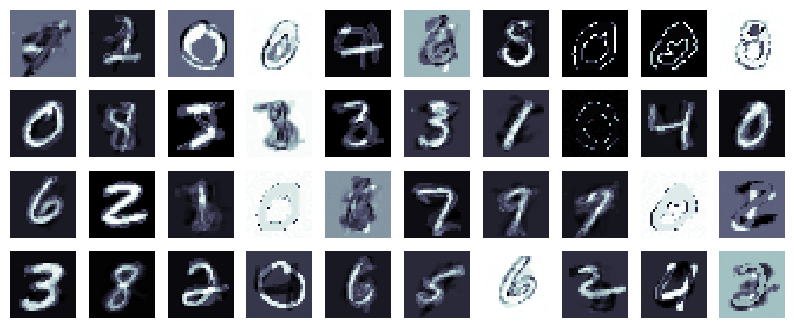

In [104]:
row_size = 10
col_size = int(layer_size / row_size)

figure(figsize=(row_size, col_size))

DO = np.exp((W-0.5)**2 * -20.0)
SO = DO * (S/WinC)
WS = W * (S/WinC)
print('DO', DO.shape, DO.max(), DO.min(), np.median(DO))
print('SO', SO.shape, SO.max(), SO.min(), np.median(SO))
print('WS', WS.shape, WS.max(), WS.min(), np.median(WS))
for col_idx in range(col_size):
    for row_idx in range(row_size):
        n_W_idx = col_idx * row_size + row_idx

        aimg = WS[n_W_idx].reshape(img_side, img_side)

        subplot(col_size, row_size, n_W_idx + 1)

        imshow(aimg,
               interpolation='none',
               aspect='auto',
               cmap='bone',  # seismic
            #    vmax=1,
            #    vmin=-1,
               #    vmax=np.max(np.abs(aimg)),
               #    vmin=-np.max(np.abs(aimg))
               )
        axis("off")

show()